Exercise 5

The MSE loss measures the average squared difference between the predicted output of the network and the ground truth output. By choosing this loss function, we assume that the network's output should closely match the ground truth reconstruction. The squared difference penalizes larger errors more than smaller errors, which encourages the network to produce reconstructions that are as close as possible to the ground truth.

By minimizing the MSE loss during training, the network will learn to generate reconstructions that are closer to the ground truth, thereby improving the overall reconstruction quality.

In [3]:
from MNIST_dataloader import Noisy_MNIST
from Fast_MRI_dataloader import Fast_MRI
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torch.utils.data import TensorDataset
import glob
import numpy as np
from tqdm.auto import tqdm 
from PIL import Image
import numpy as np
from torch.fft import fft2, fftshift, ifft2, ifftshift

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
# %% dataloader for the Fast MRI dataset
def create_dataloaders_mri(data_loc, batch_size):
    dataset_train = Fast_MRI("train", data_loc)
    dataset_test  = Fast_MRI("test" , data_loc)
    
    Fast_MRI_train_loader =  DataLoader(dataset_train, batch_size=batch_size, shuffle=True,  drop_last=False)
    Fast_MRI_test_loader  =  DataLoader(dataset_test , batch_size=batch_size, shuffle=True, drop_last=False)
    
    return Fast_MRI_train_loader, Fast_MRI_test_loader

In [6]:
# Bram
#data_loc = 'D://5LSL0-Datasets//Fast_MRI_Knee' #change the datalocation to something that works for you
#Amin 
data_loc = 'C:/Users/amin2/Documents/School/5LSL0ML/5LSL0/data/Fast_MRI_Knee'


# define parameters
batch_size = 8

train_loader, test_loader = create_dataloaders_mri(data_loc, batch_size)

100%|██████████| 31/31 [00:01<00:00, 15.57it/s]


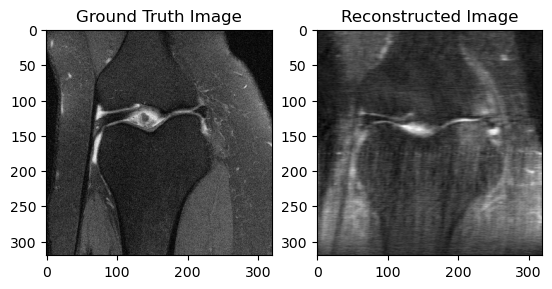

In [7]:
# go over the dataset
for i,(kspace, M, gt) in enumerate(tqdm(train_loader)):
    pass

# go over the dataset
for i,(kspace_t, M_t, gt_t) in enumerate(tqdm(test_loader)):
    pass

# Define function to achieve Full k-space
def get_k_space(inputs):
    # get the k-space

    k_space = fftshift(fft2(inputs))
    return k_space

# Define function to achieve Partial k-space from Full k-space and Mask
def get_partial_k_space(input,M):
    return  torch.mul(input, M)

def get_accelerate_MRI(inputs):
    return ifft2(inputs)

# Run Full k-space function
k_space = get_k_space(gt)
kspace_plot = torch.log(torch.abs(k_space)+1e-20)

# Run Partial k-sapce function
par_k_space = get_partial_k_space(k_space[0], M[0])

# Run Accelerated MRI function
acc_mri = get_accelerate_MRI(par_k_space)
acc_mri_plot = torch.abs(acc_mri)
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2)

# Plot the reconstructed image in the first subplot
axes[0].imshow(gt[0], cmap='gray')
axes[0].set_title('Ground Truth Image')

# Plot the ground truth image in the second subplot
axes[1].imshow(acc_mri_plot, cmap='gray')
axes[1].set_title('Reconstructed Image')
#plt.imshow(acc_mri_plot[0])

# Run Full k-space function
k_space_t = get_k_space(gt_t)

# Run Partial k-sapce function
par_k_space_t = get_partial_k_space(k_space_t, M_t)

# Run Accelerated MRI function
acc_mri_t = get_accelerate_MRI(par_k_space_t)



In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.deconv1 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.deconv2(x)
        x = self.deconv1(x)
        return x

In [9]:
# Create an instance of the ReconstructionNet
model = ConvNet()

# Define the loss function
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
# Train the model
train_losses = []
test_losses = []
num_epochs = 10

In [11]:
#model.to(device)

In [12]:
for epoch in range(num_epochs):
    train_loss = 0.0
    count = 0

    # Training loop
    model.train()
    loop = tqdm(train_loader)
    loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
    for i,(kspace, M, gt) in enumerate(loop):
        gt_label = gt.unsqueeze(1)
        kspace_input = kspace.unsqueeze(1)
        # get accelerated MRI image from partial k-space
        acc_mri = torch.abs(ifft2(kspace_input))
        #acc_mri = np.transpose(acc_mri, (0, 3, 1, 2))
        optimizer.zero_grad()

        outputs = model(acc_mri)

        loss = loss_fn(outputs, gt_label)
        loss.backward()
        count+=1
        optimizer.step()
        train_loss += loss.item() #* kspace_input.size(0)
        loop.set_postfix(loss=loss.item())
    count_test = 0
    test_loss = 0
    # Testing loop
    model.eval()
    with torch.no_grad():
       loop = tqdm(test_loader)
       for i,(kspace_t, M_t, gt_t) in enumerate(loop):
            gt_label_t = gt_t.unsqueeze(1)
            kspace_input_t = kspace_t.unsqueeze(1)

            # get accelerated MRI image from partial k-space
            acc_mri_t = torch.abs(ifft2(kspace_input_t))

            outputs = model(acc_mri_t)
            count_test +=1
            loss = loss_fn(outputs, gt_label_t)
            test_loss += loss.item()# * kspace_input_t.size(0)
            loop.set_postfix(loss=loss.item())

    # Calculate average losses
    train_loss /= count
    test_loss /= count_test

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # Print epoch-wise loss
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

# Save the trained model   
torch.save(model.state_dict(), 'Ex6_trained.pth')

100%|██████████| 31/31 [00:09<00:00,  3.24it/s, loss=0.0207]


Epoch 1: Train Loss = 0.0620, Test Loss = 0.0209


100%|██████████| 31/31 [00:10<00:00,  3.04it/s, loss=0.0121]


Epoch 2: Train Loss = 0.0203, Test Loss = 0.0145


100%|██████████| 31/31 [00:10<00:00,  2.99it/s, loss=0.0196]


Epoch 3: Train Loss = 0.0192, Test Loss = 0.0145


100%|██████████| 31/31 [00:10<00:00,  2.89it/s, loss=0.0111]


Epoch 4: Train Loss = 0.0187, Test Loss = 0.0150


100%|██████████| 31/31 [00:10<00:00,  2.95it/s, loss=0.0173]


Epoch 5: Train Loss = 0.0187, Test Loss = 0.0166


100%|██████████| 31/31 [00:11<00:00,  2.68it/s, loss=0.0154] 


Epoch 6: Train Loss = 0.0189, Test Loss = 0.0142


100%|██████████| 31/31 [00:10<00:00,  3.02it/s, loss=0.0151]


Epoch 7: Train Loss = 0.0181, Test Loss = 0.0148


100%|██████████| 31/31 [00:10<00:00,  3.01it/s, loss=0.0139]


Epoch 8: Train Loss = 0.0179, Test Loss = 0.0155


100%|██████████| 31/31 [00:11<00:00,  2.78it/s, loss=0.0158]


Epoch 9: Train Loss = 0.0184, Test Loss = 0.0145


100%|██████████| 31/31 [00:10<00:00,  2.94it/s, loss=0.0132]

Epoch 10: Train Loss = 0.0180, Test Loss = 0.0141


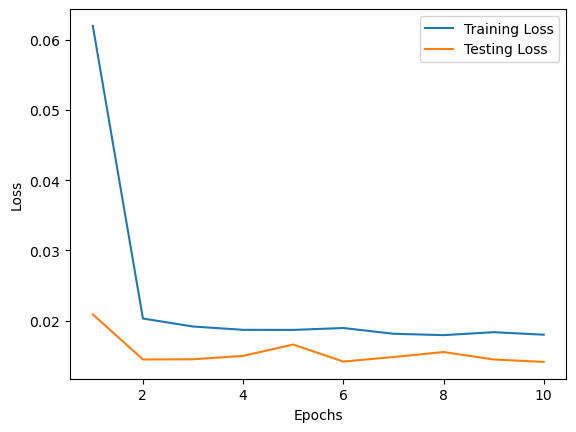

In [18]:
# Plot the training and testing loss
import matplotlib.pyplot as plt

epochs = range(1, num_epochs +1)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# Get accelerated MRI input
accelerated_mri_input = get_accelerate_MRI(kspace)
accerated_plot = torch.log(torch.abs(accelerated_mri_input)+1e-20)

In [20]:
# Select model and load pre-trained weights
model = ConvNet()
model.load_state_dict(torch.load('Ex6_trained.pth'))
model.eval()

outputs = []
gts = []
accerated_plots = []

with torch.no_grad():
    for i, (kspace_t, M_t, gt_t) in enumerate(tqdm(test_loader, leave=False)):
        kspace_input_t = kspace_t.unsqueeze(1)
        acc_mri_t = torch.abs(ifft2(kspace_input_t))
        accelerated_mri_input = get_accelerate_MRI(kspace_t)
        accerated_plot = torch.log(torch.abs(accelerated_mri_input) + 1e-20)
        
        gts.append(gt_t)
        
        output = model(acc_mri_t)
        outputs.append(output)
        accerated_plots.append(accerated_plot)
        
        if len(outputs) == len(gts) == len(accerated_plots) == 32:
            break

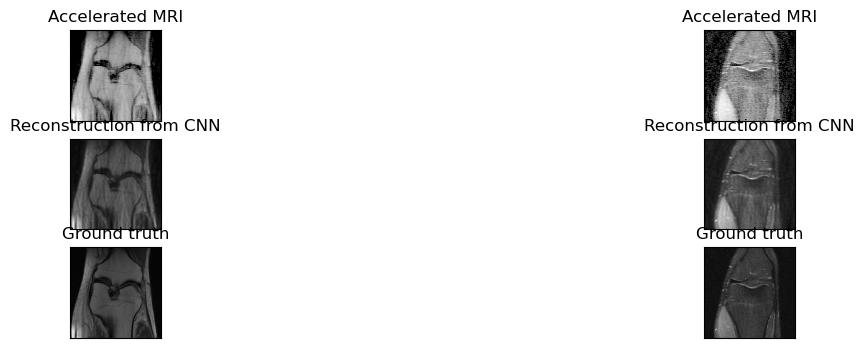

In [22]:
# Define the number of rows and columns for the subplot grid
num_rows = 3
num_cols = 2

# Create a figure and subplots with the desired grid layout
fig, axs = plt.subplots(num_rows, num_cols)

output_np = outputs[0].squeeze(1).numpy()

# Loop over the batch_size
for i in range(num_cols):
    # Plot Accelerated MRI
    axs[i//num_cols, i%num_cols].imshow(accerated_plots[0].numpy()[i], vmin=-2, interpolation='nearest', cmap='gray')
    axs[i//num_cols, i%num_cols].set_xticks([])
    axs[i//num_cols, i%num_cols].set_yticks([])
    axs[i//num_cols, i%num_cols].set_title('Accelerated MRI')

    # Plot Reconstruction from ISTA
    axs[(i+num_cols)//num_cols, (i+num_cols)%num_cols].imshow(outputs[0].squeeze(1).numpy()[i], cmap='gray')
    axs[(i+num_cols)//num_cols, (i+num_cols)%num_cols].set_xticks([])
    axs[(i+num_cols)//num_cols, (i+num_cols)%num_cols].set_yticks([])
    axs[(i+num_cols)//num_cols, (i+num_cols)%num_cols].set_title('Reconstruction from CNN')

    # Plot Ground truth
    axs[(i+2*num_cols)//num_cols, (i+2*num_cols)%num_cols].imshow(gts[0].numpy()[i], cmap='gray')
    axs[(i+2*num_cols)//num_cols, (i+2*num_cols)%num_cols].set_xticks([])
    axs[(i+2*num_cols)//num_cols, (i+2*num_cols)%num_cols].set_yticks([])
    axs[(i+2*num_cols)//num_cols, (i+2*num_cols)%num_cols].set_title('Ground truth')


# Save figure
plt.savefig("Comparison_3b.png",dpi=500,bbox_inches='tight')
# Show the figure
plt.show()

In [17]:
import torch.nn.functional as F

# Calculate average MSE
total_mse = 0.0
num_samples = len(range(gts[0].size(0)))

for i in range(num_samples):
    mse = F.mse_loss(outputs[0].squeeze(1)[i], gts[0].squeeze(1)[i])
    total_mse += mse.item()

average_mse = total_mse / num_samples

print(f"Average MSE: {average_mse:.4f}")

Average MSE: 0.0183
